In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [2]:
# parameters
simulation_start_year = 2021
simulation_end_year_string = "2022-11-01" 
format = "%Y-%m-%d"
simulation_end_year = datetime.strptime(simulation_end_year_string, format)
weeks_off_bt_crops = 2
actual_yield_percentage = 0.87

In [3]:
df_G = pd.read_csv("grower_list.csv")

In [4]:
df_G.head()

,Site No.,Address,Med_Rec,Grower Class,Num Plants
0,1,"1680 B Marquette Avenue Bay City, MI",Medical,C,1500
1,2,"1204 West US Highway 2 Germfask, MI",Medical,C,1500
2,3,"1230 Mason Court Webberville, MI",Medical,C,1500
3,4,"34280 56th Street Bangor, MI",Medical,C,1500
4,5,"21055 E M48 Detour, MI",Medical,C,1500


In [5]:
df_A = pd.read_csv("assumptions.csv")

In [6]:
df_A

,#,Grow type,Weeks to harvest (low),Weeks to harvest (high),Begin week (low),Begin week (high),Ounces per plant (low),Ounces per plant (high)
0,1,Outdoor,24,32,13,24,10,17
1,2,Indoor - seed,12,16,1,27,5,15
2,3,Indoor - clone,9,16,1,24,5,15


In [7]:
np.random.seed(int(datetime.now().timestamp()))

In [8]:
random = np.random.randint(0, 3, size=len(df_G))  # 0 = Outdoor, 1 = Indoor-seed, 2 = Indoor-clone

In [9]:
# function to run one grow cycle for both indoor and outdoor crops
def cycle_initial(crop_type):
    
    start_week = []; grow_duration = []; plant_size = [];
    
    for i in crop_type:
        start_week.append(np.random.randint(df_A['Begin week (low)'][i], df_A['Begin week (high)'][i])) 
        grow_duration.append(np.random.normal(np.mean([df_A['Weeks to harvest (low)'][i], df_A['Weeks to harvest (high)'][i]])))
        plant_size.append(np.random.normal(np.mean([df_A['Ounces per plant (low)'][i], df_A['Ounces per plant (high)'][i]])))
    
    harvest_time = [start_week[i] + grow_duration[i] for i in np.arange(len(crop_type))]
    harvest_week = [round(h) for h in harvest_time]
    return harvest_week, plant_size

In [10]:
harvest_week, plant_size = cycle_initial(random)   # randomly select which growers are outdoor or indoor

In [11]:
# convert week integers to dates
harvest_dates = []  
for w in harvest_week:
    y = simulation_start_year + int(w / 52)  # int truncates
    w = w % 52 + 1  # +1 for first week, because can't have week=0 in the iso func below
    harvest_dates.append(datetime.fromisocalendar(y, w, 1))  # (year, week, day of week)

In [12]:
df_G['Harvest Date'] = harvest_dates
print(type(harvest_dates[0]))
print(df_G['Harvest Date'].head())

temp = harvest_dates[0] + timedelta(weeks=3)
temp_ser = df_G['Harvest Date'] + timedelta(weeks=3)
print(type(temp))
print(type(temp_ser))
print(temp_ser)

df_G['Plant Oz'] = plant_size
df_G['Crop Type'] = random

<class 'datetime.datetime'>
0   2021-06-28
1   2021-05-17
2   2021-11-29
3   2021-11-29
4   2021-08-09
Name: Harvest Date, dtype: datetime64[ns]
<class 'datetime.datetime'>
<class 'pandas.core.series.Series'>
0     2021-07-19
1     2021-06-07
2     2021-12-20
3     2021-12-20
4     2021-08-30
         ...    
319   2021-06-14
320   2021-11-22
321   2021-07-05
322   2021-12-13
323   2021-12-20
Name: Harvest Date, Length: 324, dtype: datetime64[ns]


In [13]:
df_G.head()

,Site No.,Address,Med_Rec,Grower Class,Num Plants,Harvest Date,Plant Oz,Crop Type
0,1,"1680 B Marquette Avenue Bay City, MI",Medical,C,1500,2021-06-28,9.789889,2
1,2,"1204 West US Highway 2 Germfask, MI",Medical,C,1500,2021-05-17,10.198318,1
2,3,"1230 Mason Court Webberville, MI",Medical,C,1500,2021-11-29,14.138249,0
3,4,"34280 56th Street Bangor, MI",Medical,C,1500,2021-11-29,13.167265,0
4,5,"21055 E M48 Detour, MI",Medical,C,1500,2021-08-09,9.354408,2


In [14]:
# conducts another cycle depending on date
def cycle_again(df_inp):

    start_date = []
    
    df = df_inp[df_inp['Harvest Date'] < simulation_end_year]  # get dataframe with only harvest dates less than the specified end date
    start_date = (df['Harvest Date'] + timedelta(weeks = 3))  # weeks_off_bt_crops))  # set second round start dates 
    df = df.drop(['Harvest Date', 'Plant Oz'], axis=1)  # drop these columns because going to simulate a second time
    
    grow_duration = []
    plant_size = []
    
    for i in df['Crop Type']:
        grow_duration.append(timedelta(weeks=(np.random.normal(np.mean([df_A['Weeks to harvest (low)'][i], df_A['Weeks to harvest (high)'][i]])))))
        plant_size.append(np.random.normal(np.mean([df_A['Ounces per plant (low)'][i], df_A['Ounces per plant (high)'][i]])))
    
    harvest_dates = []
    harvest_dates = [start_date.iloc[j] + grow_duration[j] for j in np.arange(len(df['Crop Type']))]
    
    df['Harvest Date'] = harvest_dates  # put new dates and plant sizes back in df
    df['Plant Oz'] = plant_size
    
    df_out = df
    return df_out

In [15]:
i = 0
df_2 = df_G

In [16]:
while df_2.shape[0] > 0:
    print("cycle: ", i)
    df_2 = cycle_again(df_2)
    print("df_2 ", df_2.shape[0])
    df_G = pd.concat([df_G, df_2], axis=0)
    print("df_G ", df_G.shape[0])
    i += 1

cycle:  0
df_2  324
df_G  648
cycle:  1
df_2  324
df_G  972
cycle:  2
df_2  204
df_G  1176
cycle:  3
df_2  204
df_G  1380
cycle:  4
df_2  136
df_G  1516
cycle:  5
df_2  16
df_G  1532
cycle:  6
df_2  0
df_G  1532


In [17]:
# fewer growers should be outdoors

In [18]:
#df_all = pd.concat([df_G, df_in], axis=0)
df_all = df_G

In [19]:
df_all.head()

,Site No.,Address,Med_Rec,Grower Class,Num Plants,Harvest Date,Plant Oz,Crop Type
0,1,"1680 B Marquette Avenue Bay City, MI",Medical,C,1500,2021-06-28,9.789889,2
1,2,"1204 West US Highway 2 Germfask, MI",Medical,C,1500,2021-05-17,10.198318,1
2,3,"1230 Mason Court Webberville, MI",Medical,C,1500,2021-11-29,14.138249,0
3,4,"34280 56th Street Bangor, MI",Medical,C,1500,2021-11-29,13.167265,0
4,5,"21055 E M48 Detour, MI",Medical,C,1500,2021-08-09,9.354408,2


In [20]:
df_all['Harvest Amnt'] = df_all['Plant Oz'] * df_all['Num Plants'] * actual_yield_percentage

In [21]:
# make a weekly plot
# show results in pounds

In [22]:
df_all['Harvest Month'] = df_all['Harvest Date'].apply(lambda x: x.strftime('%Y-%m'))
df_plot = df_all.groupby(by=['Harvest Month'])['Harvest Amnt'].sum().reset_index()

In [23]:
df_all['Harvest Month'].max()

'2023-03'

Text(0, 0.5, 'Oz of Plant Harvested')

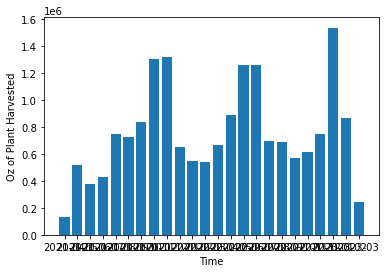

In [24]:
plt.bar(df_plot['Harvest Month'], df_plot['Harvest Amnt'])
plt.xlabel("Time")
plt.ylabel("Oz of Plant Harvested")

In [25]:
df_out_in_in = df_all[df_all['Crop Type'] == 1]

Text(0, 0.5, 'Ounces of Plant Harvested')

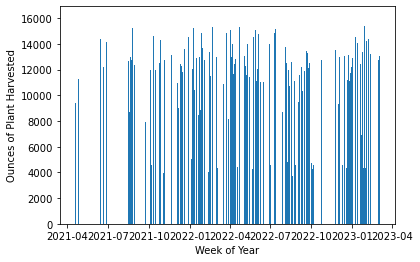

In [26]:
plt.bar(df_out_in_in['Harvest Date'], df_out_in_in['Harvest Amnt']); plt.xlabel("Week of Year"); plt.ylabel("Ounces of Plant Harvested")

In [27]:
x = 2